# Case Study 10: Imputation
## Summary
Strategies for dealing with missing data are a necessary component of the analysis of any new dataset. In most cases, rather than removing records containing missing values, the preferred method is making an educated guess as to what the missing value might be and imputing the datapoint with a best guess estimate. Imputation is a method that preserves the useful data present within a dataset, while providing machine learning algorithms with the complete data they demand.

# Imputation
### November 1, 2020
### Stuart Miller, Paul Adams, and Justin Howard

# **Introduction**

Strategies for dealing with missing data are a necessary component of the analysis of any new dataset. In most cases, rather than removing records containing missing values, the preferred method is making an educated guess as to what the missing value might be and imputing the datapoint with a best guess estimate. Imputation is a method that preserves the useful data present within a dataset, while providing machine learning algorithms with the complete data they demand.

Like any other phenomena, missing data follows predictable patterns. The imputation strategy that the analyst applies should take into account why the data is missing. To accurately identify the latent patterns causing missing data, the analyst must carefully observe the data that is present for patterns. Data can be missing at random, missing not at random, and missing completely at random. While these categories appear to be very similar, knowing the differences in the patterns they describe can make the difference that leads to a high performing model. 

# **Types of Missing Data**

A commonly occuring kind of "missingness" is data that is missing at random. When missing data occur randomly, without a noticeable pattern, but the missing data can be modeled, then they are considered missing at random. The existing data can be used to fit a model that predicts what these values may be. 

Data that is missing not at random means that the probability of "missingness" is not random, but is not known. An example of this phenomenon is missing data due to a sensor wearing out over time. We may not have a model that accurately predicts when missing data will occur, but we do know that it will occur.

Data that is missing completely at random is a less common occurance. All data points have an equal probability of "missingness", which cannot be predicted, and the cause of the missingness is unknown. An example of data that is missing completely at random are data not inlcuded in the random sample of a population. 

# **The Dataset**
The dataset is composed of over 30,471 Russian home prices with 292 continuous and categorical features to inform home price predictions. Approximately 47% of the entire dataset is missing data, distributed over 51 columns. Missing datapoints are either missing at random or missing not at random.

# **Imputation Methods**

Given that the focus of this study is on imputation methods, we will not delete records from the dataset. Instead, we will explore the dataset for patterns that allow us to interpolate the missing data we observe. The primary means of imputing the data will be univariate inference and Scikit-Learn implementations of a KNN imputation approach and the Iterative Imputation\footnotemark.

\footnotetext{https://scikit-learn.org/stable/modules/impute.html}

In [45]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
df = pd.read_csv('./data/train.csv')
df.shape

(30471, 292)

In [3]:
names = df.columns
names[10:30]

Index(['state', 'product_type', 'sub_area', 'area_m', 'raion_popul',
       'green_zone_part', 'indust_part', 'children_preschool',
       'preschool_quota', 'preschool_education_centers_raion',
       'children_school', 'school_quota', 'school_education_centers_raion',
       'school_education_centers_top_20_raion', 'hospital_beds_raion',
       'healthcare_centers_raion', 'university_top_20_raion',
       'sport_objects_raion', 'additional_education_raion',
       'culture_objects_top_25'],
      dtype='object')

#### First, get list of all records with missing values. See if we can drop them all
#### Recognized there are no records without missing information
#### Next, if we can drop them all, we can run random forest to see which features are most important.
#### Finally, we can impute in order of importance; for most important features, we will impute them first, then work downward.

In [29]:
df.shape

(30471, 292)

## A count of all missing values

In [25]:
nullList = df.isnull().sum()
na_list=nullList[nullList>0].sort_values(ascending=False)

In [26]:
print('Count of columns with missing values: {}\nCount of columns without missing values: {}'.format(nullList[nullList>0].sort_values(ascending=False).count(), nullList[nullList==0].sort_values(ascending=False).count()))

Count of columns with missing values: 51
Count of columns without missing values: 241


In [27]:
print('Percent of dataset records with null values: {}%'.format(round(nullList[nullList>0].max()/df.shape[0]*100, 2)))

Percent of dataset records with null values: 47.39%


### A dataframe of missing values and their data types for selecting imputation algorithm

### We're assuming not every neighborhood in Moscow has a hospital, just as not every neighborhood in Dallas has a hospital.

In [28]:
df_missing = pd.DataFrame(list(zip(na_list.index, na_list.values)), columns=['feature','na_count'])
df_dtypes = pd.DataFrame(list(zip(df.dtypes.index, df.dtypes)), columns=['feature','type'])
df_missing.merge(df_dtypes, how='inner', on='feature')

feature  na_count     type
0                     hospital_beds_raion     14441  float64
1                              build_year     13605  float64
2                                   state     13559  float64
3              cafe_sum_500_min_price_avg     13281  float64
4              cafe_sum_500_max_price_avg     13281  float64
5                      cafe_avg_price_500     13281  float64
6                               max_floor      9572  float64
7                                material      9572  float64
8                                num_room      9572  float64
9                                kitch_sq      9572  float64
10                        preschool_quota      6688  float64
11                           school_quota      6685  float64
12            cafe_sum_1000_max_price_avg      6524  float64
13            cafe_sum_1000_min_price_avg      6524  float64
14                    cafe_avg_price_1000      6524  float64
15                                life_sq      6383  float64
16                build_count_before_1920      4991  float64
17                      build_count_block      4991  float64
18   raion_build_count_with_material_info      4991  float64
19                       build_count_wood      4991  float64
20                      build_count_frame      4991  float64
21                      build_count_brick      4991  float64
22                   build_count_monolith      4991  float64
23                      build_count_panel      4991  float64
24                       build_count_foam      4991  float64
25                       build_count_slag      4991  float64
26                        build_count_mix      4991  float64
27  raion_build_count_with_builddate_info      4991  float64
28                  build_count_1971-1995      4991  float64
29                  build_count_1921-1945      4991  float64
30                  build_count_1946-1970      4991  float64
31                 build_count_after_1995      4991  float64
32            cafe_sum_1500_min_price_avg      4199  float64
33            cafe_sum_1500_max_price_avg      4199  float64
34                    cafe_avg_price_1500      4199  float64
35            cafe_sum_2000_min_price_avg      1725  float64
36            cafe_sum_2000_max_price_avg      1725  float64
37                    cafe_avg_price_2000      1725  float64
38            cafe_sum_3000_min_price_avg       991  float64
39            cafe_sum_3000_max_price_avg       991  float64
40                    cafe_avg_price_3000       991  float64
41            cafe_sum_5000_max_price_avg       297  float64
42            cafe_sum_5000_min_price_avg       297  float64
43                    cafe_avg_price_5000       297  float64
44                         prom_part_5000       178  float64
45                                  floor       167  float64
46               railroad_station_walk_km        25  float64
47              railroad_station_walk_min        25  float64
48               ID_railroad_station_walk        25  float64
49                          metro_km_walk        25  float64
50                         metro_min_walk        25  float64

In [34]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [29]:
df_cats = df.select_dtypes(include=['O'])

In [30]:
df_cats2 = df_cats.drop('timestamp',axis=1)

In [37]:
print('Categorical cardinality:\n\nFeature product_type:\n{}\n\nFeature ecology:\n{}\n\nFeature sub_area:\n{}'.format(df_cats['product_type'].unique(), df_cats['ecology'].unique(), df_cats['sub_area'].unique()))

Categorical cardinality:

Feature product_type:
['Investment' 'OwnerOccupier']

Feature ecology:
['good' 'excellent' 'poor' 'satisfactory' 'no data']

Feature sub_area:
['Bibirevo' 'Nagatinskij Zaton' "Tekstil'shhiki" 'Mitino' 'Basmannoe'
 'Nizhegorodskoe' "Sokol'niki" 'Koptevo' 'Kuncevo' 'Kosino-Uhtomskoe'
 'Zapadnoe Degunino' 'Presnenskoe' 'Lefortovo' "Mar'ino" "Kuz'minki"
 'Nagornoe' "Gol'janovo" 'Vnukovo' 'Juzhnoe Tushino' 'Severnoe Tushino'
 "Chertanovo Central'noe" 'Fili Davydkovo' 'Otradnoe' 'Novo-Peredelkino'
 'Bogorodskoe' 'Jaroslavskoe' 'Strogino' 'Hovrino' "Moskvorech'e-Saburovo"
 'Staroe Krjukovo' 'Ljublino' 'Caricyno' 'Veshnjaki' 'Danilovskoe'
 'Preobrazhenskoe' "Kon'kovo" 'Brateevo' 'Vostochnoe Izmajlovo'
 'Vyhino-Zhulebino' 'Donskoe' 'Novogireevo' 'Juzhnoe Butovo' 'Sokol'
 'Kurkino' 'Izmajlovo' 'Severnoe Medvedkovo' 'Rostokino'
 'Orehovo-Borisovo Severnoe' 'Ochakovo-Matveevskoe' 'Taganskoe'
 'Dmitrovskoe' 'Orehovo-Borisovo Juzhnoe' 'Teplyj Stan' 'Babushkinskoe'
 'Pokrovs

In [38]:
df_cats2['sub_area'].isnull().sum()

0

# One-hot and label encode

In [31]:
sub_area = df_cats2['sub_area'].astype('category')
one_hots = df_cats2.drop('sub_area',axis=1)
sub_area_final = sub_area.cat.codes
one_hots_final = pd.get_dummies(one_hots)

(array([2165., 2494., 2766., 2539., 4528., 2817., 2297., 5204., 2768.,
        2893.]),
 array([  0. ,  14.5,  29. ,  43.5,  58. ,  72.5,  87. , 101.5, 116. ,
        130.5, 145. ]),
 <a list of 10 Patch objects>)

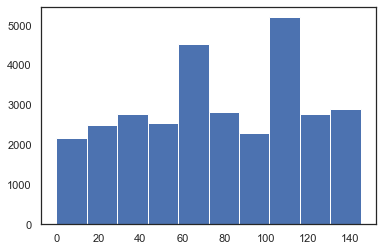

In [32]:
import matplotlib.pyplot as plt
plt.hist(sub_area.cat.codes)

In [43]:
sub_area.isna().sum()

0

In [33]:
encodes = pd.concat([sub_area_final,one_hots_final], axis=1).astype('int64')

# Get a list of the non-null values and run a model to predict price_doc
## Concatenate with encoded variables

In [45]:
print('time range: [{}, {}]'.format(df['timestamp'].min(),df['timestamp'].max()))

time range: [2011-08-20, 2015-06-30]


In [34]:
nullList = df.isnull().sum()
non_naList=nullList[nullList==0].sort_values(ascending=False)
non_null_features = list(non_naList.index)

In [47]:
df[non_null_features].dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [35]:
df_no_null = pd.concat([no_null_df, encodes], axis=1)

In [50]:
df_no_null.head()

price_doc  catering_km  zd_vokzaly_avto_km  railroad_km  ID_big_road2  \
0    5850000     0.516838           14.231961     1.305159             5   
1    6000000     0.230287            9.242586     0.694536             4   
2    5700000     0.190462            9.540544     0.700691             4   
3   13100000     0.465820           17.478380     1.999265            17   
4   16331452     0.026102            1.595898     0.084113            10   

   big_road2_km  ID_big_road1  big_road1_km  kremlin_km  bulvar_ring_km  ...  \
0      3.830951             1      1.422391   15.156211       13.675657  ...   
1      3.103996             2      2.887377    8.698054        8.132640  ...   
2      2.927487             3      0.647250    9.067885        8.054252  ...   
3      2.780449             1      2.677824   19.487005       18.309433  ...   
4      3.133531             4      1.721834    2.578671        0.787593  ...   

   water_1line_yes  big_road1_1line_no  big_road1_1line_yes  \
0                0                   1                    0   
1                0                   1                    0   
2                0                   1                    0   
3                0                   1                    0   
4                0                   1                    0   

   railroad_1line_no  railroad_1line_yes  ecology_excellent  ecology_good  \
0                  1                   0                  0             1   
1                  1                   0                  1             0   
2                  1                   0                  0             0   
3                  1                   0                  0             1   
4                  0                   1                  1             0   

   ecology_no data  ecology_poor  ecology_satisfactory  
0                0             0                     0  
1                0             0                     0  
2                0             1                     0  
3                0             0                     0  
4                0             0                     0  

[5 rows x 256 columns]

## Correlation matrix including encoded categorical data

In [15]:
# Compute the correlation matrix
corr = df_no_null.corr()

## Correlation matrix excluding categorical data

# There is no strong correlation in the dataset when there are only columns that do not contain NA

In [55]:
#pd.set_option('display.max_columns', None)
#corr

0.260420   
sport_count_3000                                         0.597260   
leisure_count_3000                                       0.941987   
mosque_count_3000                                        0.585406   
church_count_3000                                        0.895345   
big_church_count_3000                                    0.880998   
cafe_count_3000_price_high                               0.851869   
cafe_count_3000_price_4000                               0.932931   
green_part_2000                                         -0.179104   
market_count_1500                                        0.166687   
sport_count_1500                                         0.554561   
big_church_count_500                                     0.919069   
cafe_count_1000                                          0.965470   
trc_sqm_1000                                             0.730736   
trc_count_1000                                           0.786255   
office_sqm_1000                                          0.663155   
office_count_1000                                        0.824419   
prom_part_1000                                          -0.119937   
green_part_1000                                         -0.114231   
market_count_500                                         0.299841   
sport_count_500                                          0.700470   
leisure_count_500                                        0.111955   
mosque_count_500                                        -0.005885   
church_count_500                                         0.931210   
cafe_count_500_price_high                                0.809271   
cafe_count_1000_price_500                                0.963476   
cafe_count_500_price_4000                                0.916209   
cafe_count_500_price_2500                                0.951590   
cafe_count_500_price_1500                                0.846805   
cafe_count_500_price_1000                                0.742752   
cafe_count_500_price_500                                 0.898566   
cafe_count_500_na_price                                  0.917471   
cafe_count_500                                           0.926746   
trc_sqm_500                                              0.751092   
trc_count_500                                            0.609875   
office_sqm_500                                           0.471243   
office_count_500                                         0.714563   
prom_part_500                                           -0.077066   
cafe_count_1000_na_price                                 0.919835   
cafe_count_1000_price_1000                               0.900313   
leisure_count_1500                                       0.903102   
trc_count_1500                                           0.700079   
mosque_count_1500                                        0.021747   
church_count_1500                                        0.938159   
big_church_count_1500                                    0.944445   
cafe_count_1500_price_high                               0.874421   
cafe_count_1500_price_4000                               0.987977   
cafe_count_1500_price_2500                               0.957583   
cafe_count_1500_price_1500                               0.958195   
cafe_count_1500_price_1000                               0.934915   
cafe_count_1500_price_500                                0.953059   
cafe_count_1500_na_price                                 0.929347   
cafe_count_1500                                          0.959289   
trc_sqm_1500                                             0.654223   
office_sqm_1500                                          0.624658   
cafe_count_1000_price_1500                               0.948206   
office_count_1500                                        0.865692   
prom_part_1500                                          -0.153010   
green_part_1500                                        

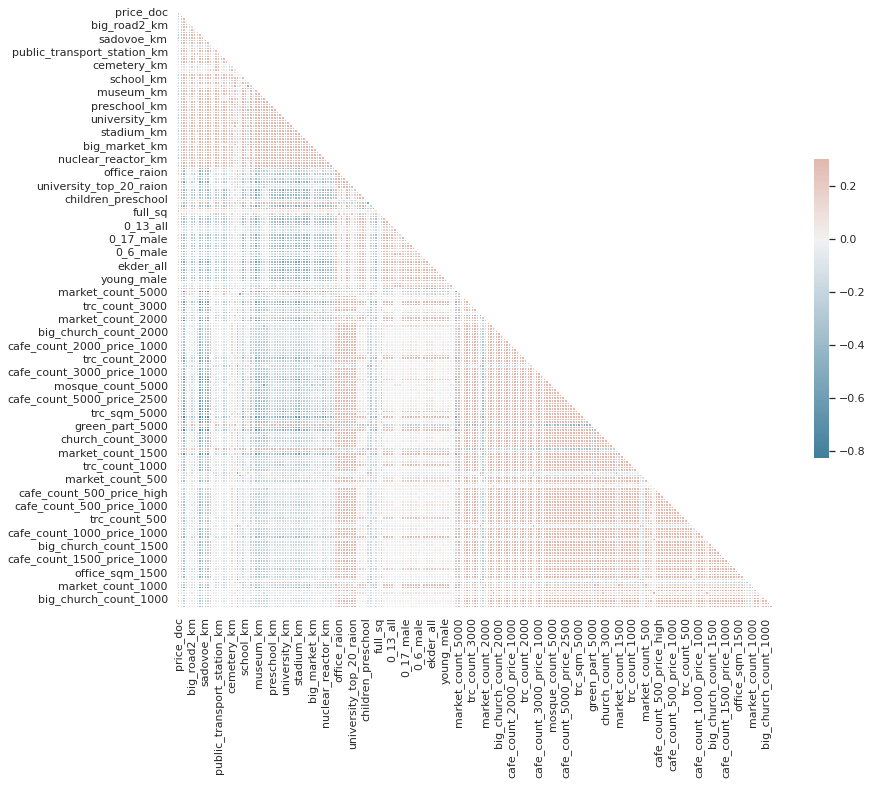

In [29]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

## PCA
There're a lot of variables, so we can apply PCA to help us visualize their importance

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_no_null_scaled = scaler.fit_transform(df_no_null)
no_null_df_scaled = scaler.fit_transform(no_null_df)

pca = PCA(n_components=2)

df_no_null_reduced = pca.fit_transform(df_no_null_scaled)
no_null_df_reduced = pca.fit_transform(no_null_df)

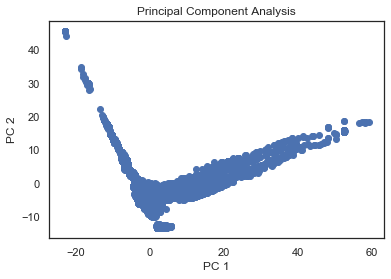

In [32]:
plt.scatter(df_no_null_reduced[:,0], df_no_null_reduced[:,1])
plt.title('Principal Component Analysis: df_no_null')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [66]:
pca = PCA(n_components=2)

df_no_null_reduced = pca.fit_transform(df_no_null_scaled)

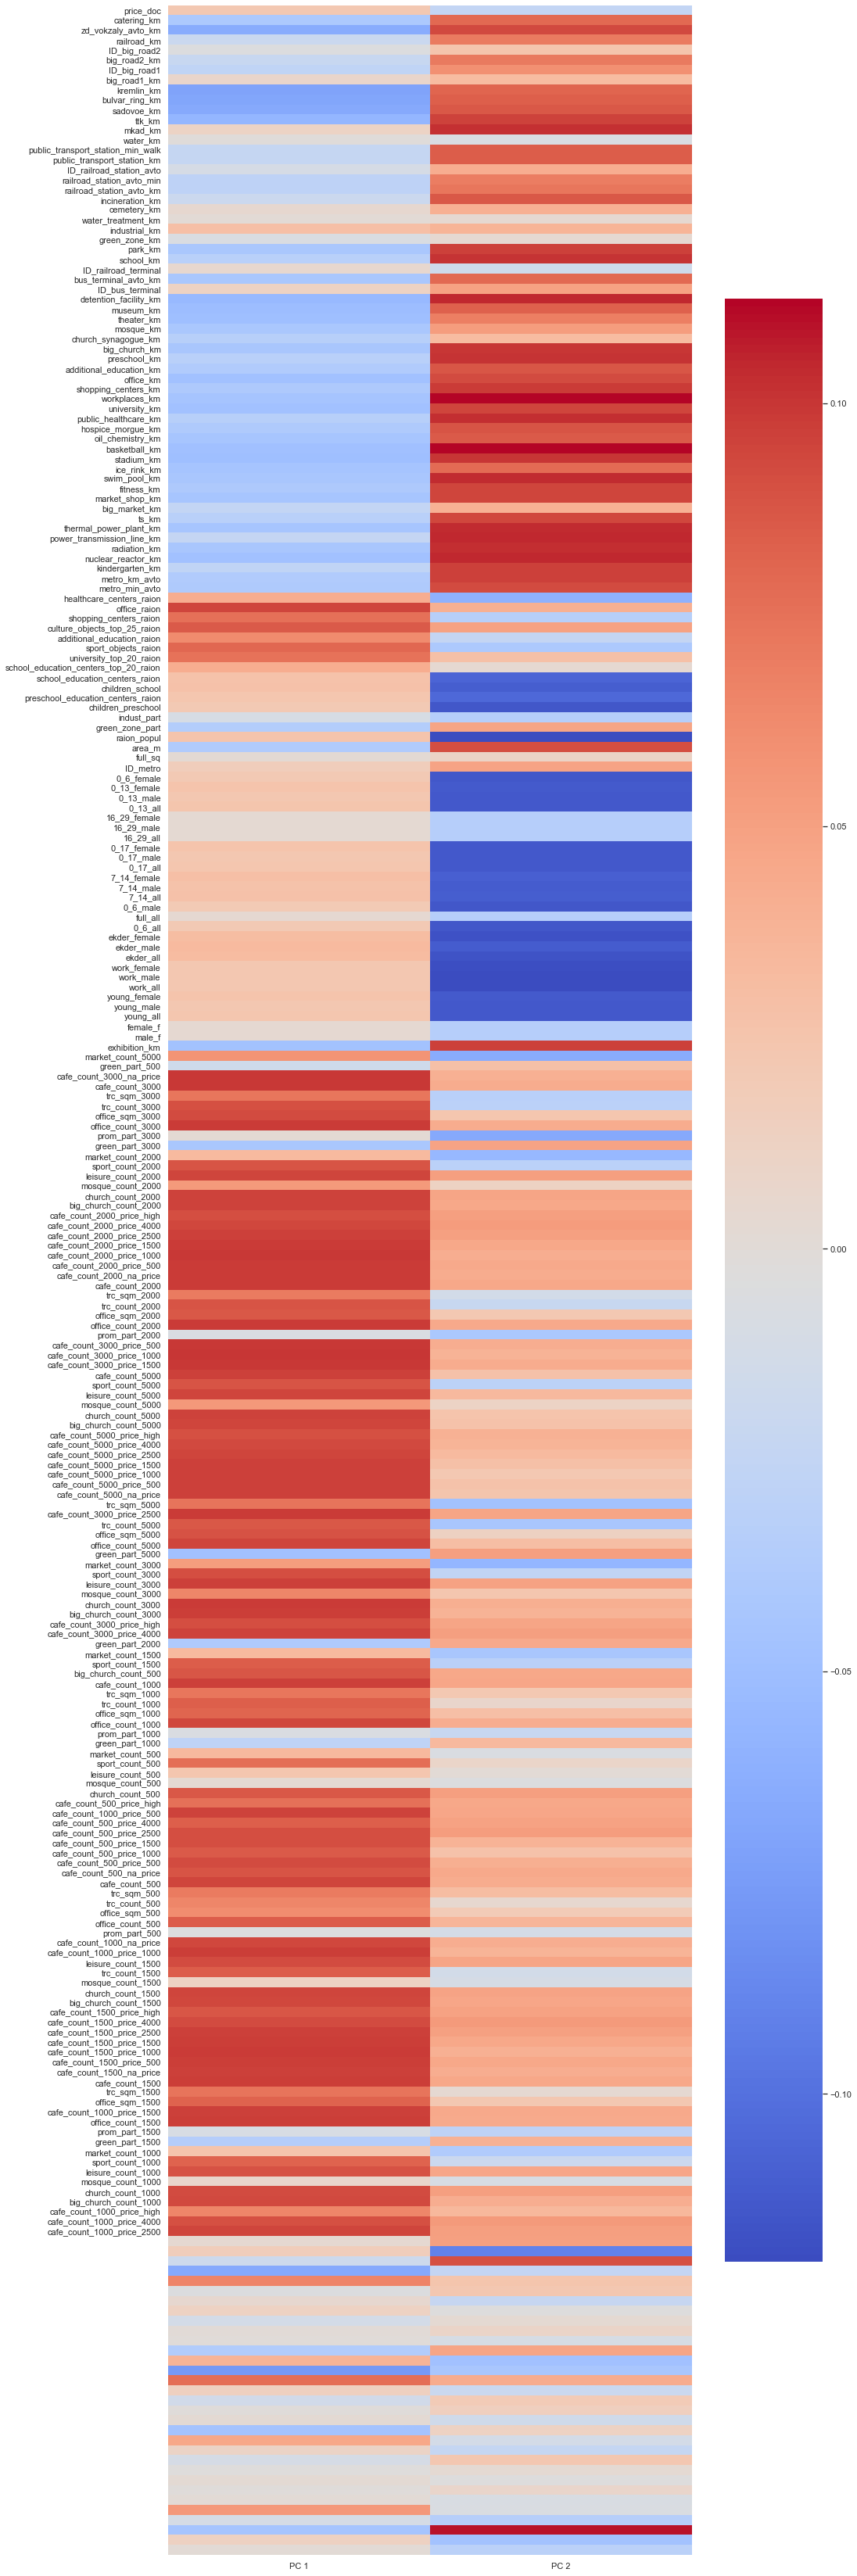

In [67]:
plt.rcParams['figure.figsize'] = (15, 60)
ax = sns.heatmap(pca.components_.T,
                 cmap='coolwarm',
                 xticklabels=['PC ' + str(x) for x in range(1,pca.n_components_+1)],
                 yticklabels=list(no_null_df.columns)
                 )

# Running a linear regression on price_doc to assess model performance without variables having missing values. This will be compared again after imputing

In [70]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = df_no_null['price_doc']
X = df_no_null.drop(['price_doc'], axis=1)
normalized_X = preprocessing.normalize(X)
X_normalized = pd.DataFrame(normalized_X, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.33, random_state=42)

In [69]:
regress = linear_model.LinearRegression()
regress.fit(X_train, y_train)
y_preds = regress.predict(X_test)
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_preds)))

Mean Squared Error: 12620102690104.59


In [72]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# set a random seed for reproducibility
random_seed = 42
# define the estimator
linearRegress = LinearRegression()
# provide the parameters of the feature selection process
feature_selector = RFECV(linearRegress,
          step = 1,
          min_features_to_select= 1,
          cv = 5,
          n_jobs = -1) 
# create an 80:20 train:test set split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = random_seed, test_size = .20)
print('X_train shape: ', X_train.shape, '\ny_train shape: ', y_train.shape, 
      '\nX_test shape: ', X_test.shape, '\ny_test shape: ', y_test.shape)

X_train shape:  (24376, 255) 
y_train shape:  (24376,) 
X_test shape:  (6095, 255) 
y_test shape:  (6095,)


In [73]:
# fit the selector to the training set 
feature_selector = feature_selector.fit(X_train, y_train)

Optimal number of features : 116


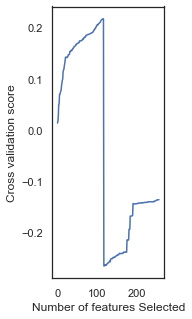

In [82]:
# visualize the results
print('Optimal number of features : %d' % feature_selector.n_features_)
plt.figure()
plt.xlabel('Number of features Selected')
plt.ylabel('Cross validation score')
plt.plot(range(1,len(feature_selector.grid_scores_) +1), feature_selector.grid_scores_)
plt.show()

In [90]:
df_no_null.columns[116]

'sport_count_2000'

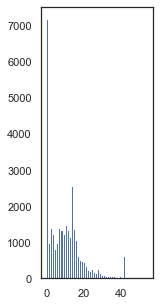

In [96]:
plt.hist(df_no_null['sport_count_2000'], bins = 50);

In [97]:
df_no_sport = df_no_null.drop('sport_count_2000', axis = 1)
feature_selector = feature_selector.fit(X_train, y_train)
# visualize the results
print('Optimal number of features : %d' % feature_selector.n_features_)
plt.figure()
plt.xlabel('Number of features Selected')
plt.ylabel('Cross validation score')
plt.plot(range(1,len(feature_selector.grid_scores_) +1), feature_selector.grid_scores_)
plt.show()

### Using Ordinary Least Squares to check out serial correlation and feature importance relative to price_doc (y)

In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(X_normalized)
est = sm.OLS(y, X2)
est2 = est.fit()
#est2.summary(alpha=0.05)

### Durbin-Watson test statistic using lag-1 horizons indicate - with a value almost equal to 2 - that there is a very minimal risk of serial correlation. Therefore, a time series model is not required.

In [130]:
import statsmodels
resids = y_test-y_preds
print('Durbin-Watson test for serial correlation (lag-1 auto-correlation): {}'.format(round(statsmodels.stats.stattools.durbin_watson(resids, axis=0),3)))

Durbin-Watson test for serial correlation (lag-1 auto-correlation): 1.978


### A low adjusted r-squared indicates there is too much multi-collinearity in the data and the right features may not be included. Therefore, imputation is necessary.

In [131]:
print('Adjusted R-Square: {}'.format(round(est2.rsquared_adj, 3)))

Adjusted R-Square: 0.377


### The very low value of the smallest eigenvalue also indicates strong multi-collinearity by suggesting the matrix is close to singular

In [132]:
est2.eigenvals.min()

3.042230987622032e-28

In [159]:
print('Percent of features that are statistically significant: {}%'.format(round(est2.pvalues[est2.pvalues < 0.05].count() / est2.pvalues.count()*100, 2)))

Percent of features that are statistically significant: 49.61%


In [185]:
pval_names = list(est2.pvalues[est2.pvalues < 0.05].index)
pvals = list(est2.pvalues[est2.pvalues < 0.05].values)

In [180]:
stat_sig = pd.DataFrame(list(zip(pval_names, pvals)), columns=['feature','p-value'])
stat_sig.sort_values(by='p-value').reset_index(drop=True).head()

feature       p-value
0                     full_sq  0.000000e+00
1   culture_objects_top_25_no  4.221515e-13
2  culture_objects_top_25_yes  9.667293e-12
3          leisure_count_1500  1.282035e-11
4  cafe_count_3000_price_1000  3.677676e-11

# After running a linear regression on the data without imputing any values and only using columns that do not have missing information, we have an error of

### Hospital bed imputation

In [43]:
print('Percent of hospital_beds_raion with missing values: {}%'.format(round(100*df['hospital_beds_raion'].isna().sum()/df.shape[0],2)))

Percent of hospital_beds_raion with missing values: 47.39%


In [36]:
neighborhoods = pd.concat([df['sub_area'],df['hospital_beds_raion']], axis=1)
s = neighborhoods.groupby(neighborhoods['sub_area']).sum()

#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
s.sort_values(by='sub_area', ascending=True).head() # Missing values appear as 0

hospital_beds_raion
sub_area                           
Ajeroport                  125460.0
Akademicheskoe             175130.0
Alekseevskoe                77000.0
Altuf'evskoe                    0.0
Arbat                        8430.0

Because missing values for hospital_beds_raion are missing not at random - meaning neighborhoods that have values have values across all records whereas neighborhoods that do not have values have no values across all records - we will impute missing values for hospital_beds_raion with value zero.

In [37]:
df.loc[df['hospital_beds_raion'].isna(),'hospital_beds_raion'] = 0

### Build Year Imputation
For this, we used an ensemble of a linear regression using all numeric features not containing NA and the median by sub_area for imputing build year. Mean squared error outperformed model baseline used to predict price_doc so using linear regression to impute for an input variable will not likely make the model worse.

In [38]:
df_numeric1 = pd.concat([df_no_null.select_dtypes(include=['int64','float64']), df['hospital_beds_raion'], df['build_year']], axis=1)

In [46]:
build_year_df = df_numeric1.loc[df_numeric1['build_year'].notnull(),:]
build_year_X = build_year_df.drop('build_year', axis=1)
build_year_y = build_year_df['build_year']
normalized_X = normalize(build_year_X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, build_year_y, test_size=0.33, random_state=42)
build_yr_regression = LinearRegression()
build_yr_regression.fit(X_train, y_train)
y_preds = build_yr_regression.predict(X_test)
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_preds)))

Mean Squared Error: 1443484330.353161


In [47]:
build_year_null_df = df_numeric1.loc[df_numeric1['build_year'].isnull(),:]
build_year_null_X = build_year_df.drop('build_year', axis=1)
build_year_null_y = build_year_df['build_year']
normalized_null_bldyr_X = preprocessing.normalize(build_year_null_X)

In [48]:
regress_imputed_bldyr = build_yr_regression.predict(normalized_null_bldyr_X)

Regression did not do well for imputing build year. Predicted values using the full numeric dataset resulted in predictions that houses were constructed in 43,737 BC (example 1):

In [49]:
regress_imputed_bldyr[0]

-43737.26980994413

In [50]:
df_no_null_hosp = pd.concat([df_no_null, df['hospital_beds_raion']], axis=1)

In [189]:
df_no_null_hosp.head()

price_doc  catering_km  zd_vokzaly_avto_km  railroad_km  ID_big_road2  \
0    5850000     0.516838           14.231961     1.305159             5   
1    6000000     0.230287            9.242586     0.694536             4   
2    5700000     0.190462            9.540544     0.700691             4   
3   13100000     0.465820           17.478380     1.999265            17   
4   16331452     0.026102            1.595898     0.084113            10   

   big_road2_km  ID_big_road1  big_road1_km  kremlin_km  bulvar_ring_km  \
0      3.830951             1      1.422391   15.156211       13.675657   
1      3.103996             2      2.887377    8.698054        8.132640   
2      2.927487             3      0.647250    9.067885        8.054252   
3      2.780449             1      2.677824   19.487005       18.309433   
4      3.133531             4      1.721834    2.578671        0.787593   

   sadovoe_km     ttk_km    mkad_km  water_km  \
0   13.100618  10.918587   1.422391  0.992631   
1    6.444333   3.103996   9.503405  0.698081   
2    6.963403   2.927487   5.604800  0.468265   
3   17.457198  14.606501   2.677824  1.200336   
4    0.046810   1.721834  11.616653  0.820294   

   public_transport_station_min_walk  public_transport_station_km  \
0                           3.299822                     0.274985   
1                           0.783160                     0.065263   
2                           3.945073                     0.328756   
3                           1.579164                     0.131597   
4                           0.857764                     0.071480   

   ID_railroad_station_avto  railroad_station_avto_min  \
0                         1                   6.905893   
1                         2                   4.679745   
2                         3                   1.701420   
3                         4                   5.271136   
4                       113                   2.156284   

   railroad_station_avto_km  incineration_km  cemetery_km  water_treatment_km  \
0                  5.419893         3.633334     1.804127           23.683460   
1                  3.641773         8.648587     4.655004            1.317476   
2                  1.277658        11.996480     3.381083            4.912660   
3                  3.816045        14.317640     2.017080           15.623710   
4                  1.595898        11.903910     2.936581           10.683540   

   industrial_km  green_zone_km   park_km  school_km  ID_railroad_terminal  \
0       1.080934       0.600973  2.158587   0.177975                   101   
1       0.966479       0.065321  0.550690   0.273345                    32   
2       0.939275       0.453172  0.374848   0.158072                     5   
3       0.451173       0.106125  0.078090   0.236455                    83   
4       0.392871       0.236214  0.258289   0.376838                   113   

   bus_terminal_avto_km  ID_bus_terminal  detention_facility_km  museum_km  \
0             24.292406                1               4.248036   7.389498   
1              5.706113                2              12.649879   0.709260   
2              6.710302                3               7.682303   3.156423   
3              6.734618                1               8.789894  16.041521   
4              1.423428                4               3.779781   1.800125   

   theater_km  mosque_km  church_synagogue_km  big_church_km  preschool_km  \
0   14.053047   3.932040             0.628187       0.625783      0.177975   
1    6.829889   4.841544             0.471447       0.967821      0.273345   
2    4.273200   7.922152             0.755946       3.178751      0.158072   
3   16.990677  15.300449             1.561505       1.031777      0.236455   
4    1.112486   2.584370             0.121681       0.378756      0.376838   

   additional_education_km  office_km  shopping_centers_km  workplaces_km  \
0                 0.947962   0.637189             0.648488       

In [51]:
df.loc[df['build_year'].notna(),'build_year'] = 0

In [55]:
df_bldyr = pd.concat([df['sub_area'],df['build_year']], axis=1)

In [ ]:
df_bldyr.loc[neighborhoods[neighborhoods['build_year'].notnull(),]]

In [ ]:
neighborhoods.groupby(neighborhoods[neighborhoods['build_year'].notnull(),])

In [ ]:
t = neighborhoods.groupby(neighborhoods['sub_area']).median()

In [ ]:
df_bldyr.loc[df_bldyr['build_year'].notnull(),:]

In [ ]:
neighborhoods = pd.concat([df_no_null_hosp['sub_area'],df_no_null_hosp['build_year']], axis=1)
t = neighborhoods.groupby(neighborhoods['sub_area']).median()

#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
t.sort_values(by='sub_area', ascending=True).head() # Missing values appear as 0

In [ ]:
neighborhoods.groupby(neighborhoods['sub_area']).median()

In [58]:
df.loc[df['build_year'].isna(),'build_year'] = neighborhoods.groupby(neighborhoods['sub_area']).median()

In [ ]:
df.loc[df['build_year'].isna(),'build_year']

In [60]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(df_no_null_hosp)

array([[5.85000000e+06, 5.16838085e-01, 1.42319609e+01, ...,
        0.00000000e+00, 0.00000000e+00, 2.40000000e+02],
       [6.00000000e+06, 2.30286910e-01, 9.24258552e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.29000000e+02],
       [5.70000000e+06, 1.90461977e-01, 9.54054448e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.18300000e+03],
       ...,
       [6.97095900e+06, 6.65027120e-02, 2.56994615e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.35000000e+07, 1.34565891e-01, 1.53033378e+01, ...,
        0.00000000e+00, 1.00000000e+00, 3.30000000e+03],
       [5.60000000e+06, 1.82831343e-01, 1.22434391e+01, ...,
        1.00000000e+00, 0.00000000e+00, 1.01500000e+03]])

In [61]:
y = df_no_null['price_doc']
X = df_no_null.drop(['price_doc'], axis=1)
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
y_train_buildyr = df.loc[df['build_year'].notna(),'build_year']

In [63]:
list(na_list.index)

['hospital_beds_raion',
 'build_year',
 'state',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'max_floor',
 'material',
 'num_room',
 'kitch_sq',
 'preschool_quota',
 'school_quota',
 'cafe_sum_1000_max_price_avg',
 'cafe_sum_1000_min_price_avg',
 'cafe_avg_price_1000',
 'life_sq',
 'build_count_before_1920',
 'build_count_block',
 'raion_build_count_with_material_info',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_1971-1995',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_after_1995',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',


In [63]:
nullList = df.isnull().sum()
na_list=nullList[nullList>0].sort_values(ascending=False)

13605

In [64]:
list(na_list.index)

['hospital_beds_raion',
 'build_year',
 'state',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'max_floor',
 'material',
 'num_room',
 'kitch_sq',
 'preschool_quota',
 'school_quota',
 'cafe_sum_1000_max_price_avg',
 'cafe_sum_1000_min_price_avg',
 'cafe_avg_price_1000',
 'life_sq',
 'build_count_before_1920',
 'build_count_block',
 'raion_build_count_with_material_info',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_1971-1995',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_after_1995',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',


In [76]:
df[list(na_list.index)].head()

build_year  state  cafe_sum_500_min_price_avg  cafe_sum_500_max_price_avg  \
0         NaN    NaN                         NaN                         NaN   
1         NaN    NaN                      860.00                     1500.00   
2         NaN    NaN                      666.67                     1166.67   
3         NaN    NaN                     1000.00                     1500.00   
4         NaN    NaN                      702.22                     1166.67   

   cafe_avg_price_500  max_floor  material  num_room  kitch_sq  \
0                 NaN        NaN       NaN       NaN       NaN   
1             1180.00        NaN       NaN       NaN       NaN   
2              916.67        NaN       NaN       NaN       NaN   
3             1250.00        NaN       NaN       NaN       NaN   
4              934.44        NaN       NaN       NaN       NaN   

   preschool_quota  ...  cafe_sum_5000_max_price_avg  \
0           5001.0  ...                      1185.71   
1           3119.0  ...                      1148.81   
2           1463.0  ...                      1196.43   
3           6839.0  ...                      1552.63   
4           3240.0  ...                      1411.45   

   cafe_sum_5000_min_price_avg  cafe_avg_price_5000  prom_part_5000  floor  \
0                       708.57               947.14           13.31    4.0   
1                       673.81               911.31           27.47    3.0   
2                       702.68               949.55           21.58    2.0   
3                       931.58              1242.11            3.89    9.0   
4                       853.88              1132.66           10.92    4.0   

   railroad_station_walk_km  railroad_station_walk_min  \
0                  5.419893                  65.038716   
1                  3.411993                  40.943917   
2                  1.277658                  15.331896   
3                  4.291432                  51.497190   
4                  0.853960                  10.247521   

   ID_railroad_station_walk  metro_km_walk  metro_min_walk  
0                       1.0       1.131260       13.575119  
1                       2.0       0.635053        7.620630  
2                       3.0       1.445960       17.351515  
3                       4.0       0.963802       11.565624  
4                       5.0       0.688859        8.266305  

[5 rows x 50 columns]

In [ ]:
X_train_buildyr = df.drop([na_list.index],axis=1)

Index(['build_year', 'state', 'cafe_sum_500_min_price_avg',
       'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'max_floor',
       'material', 'num_room', 'kitch_sq', 'preschool_quota', 'school_quota',
       'cafe_avg_price_1000', 'cafe_sum_1000_max_price_avg',
       'cafe_sum_1000_min_price_avg', 'life_sq', 'build_count_before_1920',
       'build_count_wood', 'build_count_block',
       'raion_build_count_with_material_info', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_panel',
       'build_count_foam', 'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_1971-1995',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_after_1995', 'cafe_sum_1500_min_price_avg',
       'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500',
       'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
       'cafe_avg_price_2000', 'cafe_sum_3000_min_price_avg',
       'cafe_

In [ ]:
#df[.loc[df['hospital_beds_raion'].isna(),'hospital_beds_raion']] = df.loc[df['life_sq'].isna(),'full_sq']

## Build_Count Features

The dataset also contains a large number of features that represent counts of homes with specific building materials. These features are counts of homes with materials, we will assume that missing values means that those materials are absent and we will impute them with 0 values. A more detailed justification of this decision is provided below.

Each of these features contain 4,991 missing values. The sub_area feature was appended to the build_count dataframe, revealing that sub-areas with the Polesenskie prefix contain all of the missing values across all of the build_count features. Of the subset of features having at least 1 missing value, a majority of the missing values were found to be in the `build_count_foam` and `build_count_panel`. Additionally, a correlation matrix revealed that `raion_build_count_with_builddate_info` and `raion_build_count_with_material_info` are almost perfectly correlated, so we chose to remove `raion_build_count_with_builddate_info` from the dataset.

In [66]:
names = df.columns
# filtering column names for the build_count features
string = ['build_count']
build_cols = [i for i in names if any(sub in i for sub in string)]
# sub_area is appended to the list to find spatial correlations
build_cols.append('sub_area')

In [62]:
# creating a subset of the build_count features
build_count_df = df[build_cols]
build_count_df.describe()

raion_build_count_with_material_info  build_count_block  \
count                          25480.000000       25480.000000   
mean                             328.660636          50.297449   
std                              277.904011          46.937628   
min                                1.000000           0.000000   
25%                              180.000000          13.000000   
50%                              273.000000          42.000000   
75%                              400.000000          72.000000   
max                             1681.000000         223.000000   

       build_count_wood  build_count_frame  build_count_brick  \
count      25480.000000       25480.000000       25480.000000   
mean          40.848430           4.954984         108.048705   
std          126.740377          14.926934         129.120421   
min            0.000000           0.000000           0.000000   
25%            0.000000           0.000000          10.000000   
50%            0.000000           0.000000          67.000000   
75%            7.000000           1.000000         156.000000   
max          793.000000          97.000000         664.000000   

       build_count_monolith  build_count_panel  build_count_foam  \
count          25480.000000       25480.000000      25480.000000   
mean              12.043642         107.236892          0.165581   
std               19.278997          88.259709          1.133023   
min                0.000000           0.000000          0.000000   
25%                2.000000          35.000000          0.000000   
50%                6.000000          92.000000          0.000000   
75%               13.000000         157.000000          0.000000   
max              127.000000         431.000000         11.000000   

       build_count_slag  build_count_mix  \
count      25480.000000     25480.000000   
mean           4.491797         0.573155   
std           13.227435         1.530126   
min            0.000000         0.000000   
25%            0.000000         0.000000   
50%            0.000000         0.000000   
75%            2.000000         0.000000   
max           84.000000         9.000000   

       raion_build_count_with_builddate_info  build_count_before_1920  \
count                           25480.000000             25480.000000   
mean                              328.328493                18.899294   
std                               277.917031                60.983271   
min                                 1.000000                 0.000000   
25%                               178.000000                 0.000000   
50%                               271.000000                 0.000000   
75%                               400.000000                 3.000000   
max                              1680.000000               371.000000   

       build_count_1921-1945  build_count_1946-1970  build_count_1971-1995  \
count           25480.000000           25480.000000           25480.000000   
mean               26.721586             141.426413              80.130377   
std                62.512263             125.427822              57.873880   
min                 0.000000               0.000000               0.000000   
25%                 0.000000              14.000000              37.000000   
50%                 2.000000             135.000000              71.000000   
75%                20.000000             216.000000             111.000000   
max               382.000000             845.000000             246.000000   

       build_count_after_1995  
count            25480.000000  
mean                61.150824  
std                114.222229  
min                  0.000000  
25%                 14.000000  
50%                 24.000000  
75%                 57.000000  
max                799.000000

In [16]:
build_count_df.isnull().sum()


raion_build_count_with_material_info     4991
build_count_block                        4991
build_count_wood                         4991
build_count_frame                        4991
build_count_brick                        4991
build_count_monolith                     4991
build_count_panel                        4991
build_count_foam                         4991
build_count_slag                         4991
build_count_mix                          4991
raion_build_count_with_builddate_info    4991
build_count_before_1920                  4991
build_count_1921-1945                    4991
build_count_1946-1970                    4991
build_count_1971-1995                    4991
build_count_after_1995                   4991
sub_area                                    0
dtype: int64

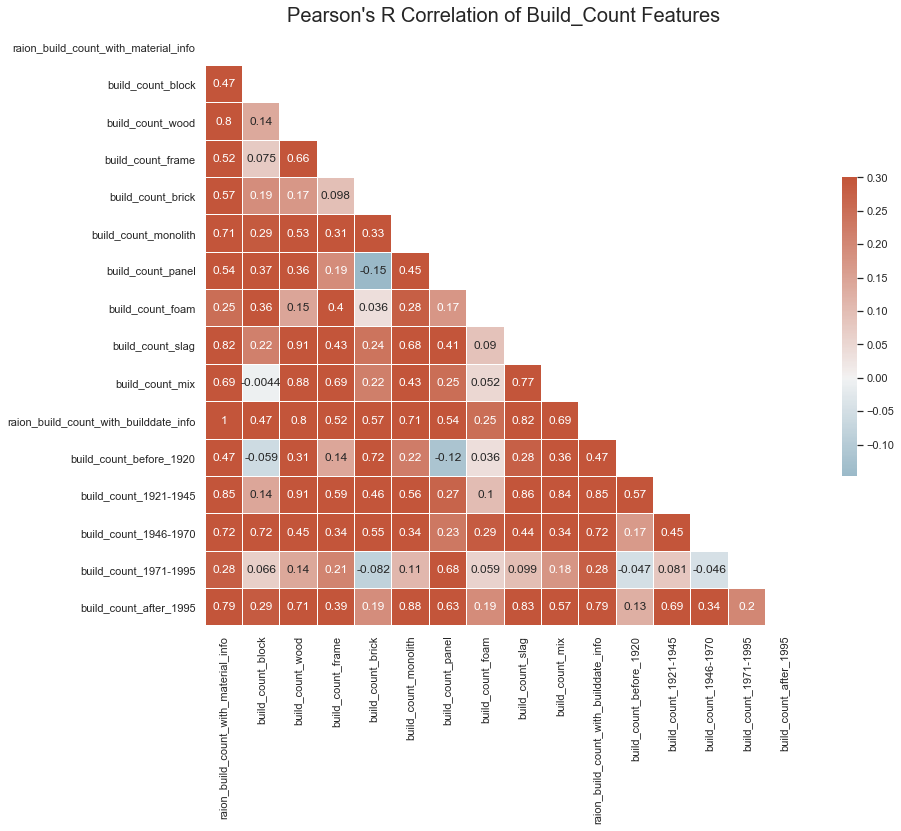

In [63]:
materials_corr = build_count_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(materials_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))
plt.title("Pearson's R Correlation of Build_Count Features", fontsize = 20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(materials_corr, mask=mask, 
                            cmap=cmap,
                            vmax=.3, 
                            center=0, 
                            square=True, 
                            linewidths=.1, 
                            annot= True,
                            cbar_kws={"shrink": .5});

In [64]:
p_regions = list(np.unique(build_count_df['sub_area']))
poselenie_areas = [i for i in p_regions if any(sub in i for sub in ['Pos'])]
poselenie_areas

['Poselenie Desjonovskoe',
 'Poselenie Filimonkovskoe',
 'Poselenie Kievskij',
 'Poselenie Klenovskoe',
 'Poselenie Kokoshkino',
 'Poselenie Krasnopahorskoe',
 'Poselenie Marushkinskoe',
 'Poselenie Mihajlovo-Jarcevskoe',
 'Poselenie Moskovskij',
 'Poselenie Mosrentgen',
 'Poselenie Novofedorovskoe',
 'Poselenie Pervomajskoe',
 'Poselenie Rjazanovskoe',
 'Poselenie Rogovskoe',
 'Poselenie Shhapovskoe',
 'Poselenie Shherbinka',
 'Poselenie Sosenskoe',
 'Poselenie Vnukovskoe',
 'Poselenie Voronovskoe',
 'Poselenie Voskresenskoe']

In [65]:
poselenie_df = build_count_df[build_count_df.sub_area.isin(poselenie_areas)]

poselenie_df.describe()

raion_build_count_with_material_info  build_count_block  \
count                           1536.000000        1536.000000   
mean                               1.987630           0.096354   
std                               11.160387           0.295172   
min                                1.000000           0.000000   
25%                                1.000000           0.000000   
50%                                1.000000           0.000000   
75%                                2.000000           0.000000   
max                              180.000000           1.000000   

       build_count_wood  build_count_frame  build_count_brick  \
count       1536.000000        1536.000000        1536.000000   
mean           1.376302           0.183594           0.035156   
std            7.499164           2.932712           0.561583   
min            0.000000           0.000000           0.000000   
25%            1.000000           0.000000           0.000000   
50%            1.000000           0.000000           0.000000   
75%            1.000000           0.000000           0.000000   
max          121.000000          47.000000           9.000000   

       build_count_monolith  build_count_panel  build_count_foam  \
count           1536.000000             1536.0            1536.0   
mean               0.003906                0.0               0.0   
std                0.062398                0.0               0.0   
min                0.000000                0.0               0.0   
25%                0.000000                0.0               0.0   
50%                0.000000                0.0               0.0   
75%                0.000000                0.0               0.0   
max                1.000000                0.0               0.0   

       build_count_slag  build_count_mix  \
count       1536.000000           1536.0   
mean           0.292318              0.0   
std            0.454976              0.0   
min            0.000000              0.0   
25%            0.000000              0.0   
50%            0.000000              0.0   
75%            1.000000              0.0   
max            1.000000              0.0   

       raion_build_count_with_builddate_info  build_count_before_1920  \
count                            1536.000000              1536.000000   
mean                                1.987630                 0.003906   
std                                11.160387                 0.062398   
min                                 1.000000                 0.000000   
25%                                 1.000000                 0.000000   
50%                                 1.000000                 0.000000   
75%                                 2.000000                 0.000000   
max                               180.000000                 1.000000   

       build_count_1921-1945  build_count_1946-1970  build_count_1971-1995  \
count            1536.000000            1536.000000            1536.000000   
mean                0.003906               1.843099               0.046875   
std                 0.062398               8.854053               0.748778   
min                 0.000000               1.000000               0.000000   
25%                 0.000000               1.000000               0.000000   
50%                 0.000000               1.000000               0.000000   
75%                 0.000000               2.000000               0.000000   
max                 1.000000             143.000000              12.000000   

       build_count_after_1995  
count             1536.000000  
mean                 0.089844  
std                  1.435157  
min                  0.000000  
25%                  0.000000  
50%                  0.000000  
75%                  0.000000  
max                 23.000000

In [185]:
nulls = build_count_df[build_count_df.isnull().any(axis=1)]
nulls['sub_area'].value_counts()

Poselenie Sosenskoe               1776
Poselenie Vnukovskoe              1372
Poselenie Voskresenskoe            713
Poselenie Filimonkovskoe           496
Poselenie Desjonovskoe             362
Poselenie Novofedorovskoe          148
Poselenie Rjazanovskoe              34
Poselenie Rogovskoe                 31
Poselenie Krasnopahorskoe           27
Poselenie Mosrentgen                19
Poselenie Voronovskoe                7
Poselenie Kievskij                   2
Poselenie Shhapovskoe                2
Poselenie Mihajlovo-Jarcevskoe       1
Poselenie Klenovskoe                 1
Name: sub_area, dtype: int64

In [67]:
for i in build_cols:
    df[i].fillna(0, inplace=True)

In [68]:
no_na = df.dropna()
no_na.shape

(9185, 292)

In [69]:
no_null_corr = no_na.corr()

In [89]:
life_corr = no_null_corr['life_sq'].sort_values(ascending=False)
life_corr.head(10)

life_sq                       1.000000
full_sq                       0.845815
num_room                      0.609960
price_doc                     0.537930
cafe_count_1500_price_2500    0.201385
cafe_count_1500_na_price      0.200318
cafe_count_3000_price_2500    0.199583
cafe_count_1500               0.199286
cafe_count_1500_price_1500    0.199174
cafe_count_2000_price_2500    0.198968
Name: life_sq, dtype: float64

In [77]:
sq_ft_features = ['life_sq', 'full_sq', 'num_room', 'price_doc']
full_sq_data = df[sq_ft_features]

In [84]:
full_sq_data['price_doc'].isnull().sum()

0

In [80]:
y = full_sq_data['price_doc']
X = full_sq_data.drop('price_doc', axis = 1)
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state)

## Multiple Imputation Strategies (Multiple Linear Regression and KNN)
### Multiple Linear Regression

In [ ]:
imp = IterativeImputer(max_iter= 10000, random_state = random_state)
imp.fit(X_train)

imp_train = imp.transform(X_train)
imp_test = imp.transform(X_test)

In [88]:
dfs = {'train--':imp_train, 'test--':imp_test}
for i, j in dfs.items():
    print(i, 'nan count: ', sum(np.isnan(j)), 'infinites: ', sum(np.isinf(j)), '\n')

train-- nan count:  [0 0 0] infinites:  [0 0 0] 

test-- nan count:  [0 0 0] infinites:  [0 0 0] 



### KNN Imputer

In [90]:
KNNimp = KNNImputer(n_neighbors = 3)
KNNimp.fit(X_train)

KNNimp_train = KNNimp.transform(X_train)
KNNimp_test = KNNimp.transform(X_test)

## Comparing the performance of Multiple Imputation Strategies

In [125]:
from sklearn.linear_model import ElasticNetCV
# instantiate the elastic net regularizer
EN = ElasticNetCV(l1_ratio = .5, 
                  cv = 5,
                  n_jobs = -1,
                  random_state = random_state)
# fit a model to the Iteratively Imputed training data
IIimputed_model = EN.fit(imp_train, y_train)
# fit the same model to the KNN Imputed training data
KNNimputed_model = EN.fit(KNNimp_train, y_train)
# predict the target using Iteratively Imputed test data
II_preds = IIimputed_model.predict(imp_test)
# predict the target using KNN imputed test data
KNN_preds = KNNimputed_model.predict(KNNimp_test)

II_MSE = np.mean((II_preds - y_test)**2)
KNN_MSE = np.mean((KNN_preds - y_test)**2)
print('Iterative Imputed model error: ', II_MSE,
      '\nKNN Imputed model error: ', KNN_MSE)

Iterative Imputed model error:  21255964463340.97 
KNN Imputed model error:  21248249768501.63


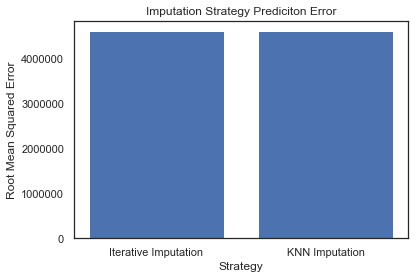

In [132]:
labels = ['Iterative Imputation', 'KNN Imputation']
errors = [np.sqrt(II_MSE), np.sqrt(KNN_MSE)]
plt.bar(range(2), errors)
plt.title('Imputation Strategy Prediciton Error')
plt.xlabel('Strategy')
plt.ylabel('Root Mean Squared Error')
plt.xticks(range(2), labels)
plt.show()

In [130]:
np.sqrt(II_MSE) -np.sqrt(KNN_MSE)

836.7346615549177